In [1]:
import tensorflow as tf
from tensorflow.python.layers.base import Layer
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from HAN import HAN
from Dataset_util import Dataset

**Improved points**:
1. retrain word2vec with &lt;UNKNOWN&gt; token
2. add regularization/distilling to attention term

In [3]:
year='2013'
word2vec_size=50
cut_long_sentence=200

word2vec_model = KeyedVectors.load_word2vec_format('data/yelp'+year+'/yelp_'+year+'_'+str(word2vec_size)+'.vector')

2018-06-08 11:46:08,649 : INFO : loading projection weights from data/yelp2013/yelp_2013_50.vector
2018-06-08 11:46:11,285 : INFO : loaded (43531, 50) matrix from data/yelp2013/yelp_2013_50.vector


In [4]:
_=word2vec_model.most_similar('ridiculous')

2018-06-08 11:46:11,293 : INFO : precomputing L2-norms of word weight vectors


In [5]:
# f_vocab=open('data/yelp'+year+'/yelp_'+year+'_500.vocab')
# index2chr={}
# chr2index={}
# index2chr[0]='<UNKNOWN>'
# chr2index['<UNKNOWN>']=0
# cnt=1
# for line in f_vocab:
#     w=line.strip().split(' ')[0]
#     index2chr[cnt]=w
#     chr2index[w]=cnt
#     cnt+=1
# f_vocab.close()
# vocab_size=cnt
# print('vocabulary size =',vocab_size)

f_vocab=open('data/yelp'+year+'/yelp_'+year+'_'+str(word2vec_size)+'.vocab')
vocab_set=[]
for line in f_vocab:
    vocab_set.append(line.strip().split(' ')[0])
vocab_set=set(vocab_set)
f_vocab.close()
print('vocabulary size =',len(vocab_set))

vocabulary size = 43531


In [6]:
def raw_data(f):
    longest_doc=-1
    longest_sen=-1
    documents=[]
    for line in f:
        this_document=[]
        cols=line.strip().split('\t\t')
        sents=cols[1].split('\t')
        for s in sents:
            this_sentence=[]
            words=s.split(' ')
            for w in words:
                if w in vocab_set:
                    this_sentence.append(w)
                else:
                    this_sentence.append('<UNKNOWN>')
            longest_sen=max(longest_sen,len(this_sentence))
            this_document.append(this_sentence)
        longest_doc=max(longest_doc,len(this_document))
        documents.append((this_document,int(cols[0])))
    return documents,longest_doc,longest_sen

In [7]:
f_train=open('data/yelp'+year+'/yelp-'+year+'-train-nonvocab.txt')
documents_train,longest_doc_train,longest_sen_train=raw_data(f_train)
f_train.close()
f_train=None

f_val=open('data/yelp'+year+'/yelp-'+year+'-dev-nonvocab.txt')
documents_val,longest_doc_val,longest_sen_val=raw_data(f_val)
f_val.close()
f_val=None

f_test=open('data/yelp'+year+'/yelp-'+year+'-test-nonvocab.txt')
documents_test,longest_doc_test,longest_sen_test=raw_data(f_test)
f_test.close()
f_test=None

In [8]:
max_doc_length=max(longest_doc_train,longest_doc_val,longest_doc_test)
max_sent_length=max(longest_sen_train,longest_sen_val,longest_sen_test)
print('maximum document length =',max_doc_length)
print('maximum sentence length =',max_sent_length)

# documents_train=documents_train[:128]

num_train=len(documents_train)
num_val=len(documents_val)
num_test=len(documents_test)

print('size of train data =',num_train)
print('size of validation data =',num_val)
print('size of test data =',num_test)

maximum document length = 100
maximum sentence length = 653
size of train data = 268006
size of validation data = 33499
size of test data = 33503


In [9]:
train=Dataset(documents_train,word2vec_model,word2vec_size,cut_long_sentence)
train_eval=Dataset(documents_train,word2vec_model,word2vec_size,cut_long_sentence)
validation=Dataset(documents_val,word2vec_model,word2vec_size,cut_long_sentence)
test=Dataset(documents_test,word2vec_model,word2vec_size,cut_long_sentence)

In [10]:
train.start_epoch()
corpora,l,a,labels=train.next_batch(64)
print(l)
print(a)
print(l.shape)
print(a.shape)
print(corpora.shape)
# print(corpora)
print(labels)

[ 1  6  3 11  3  7  9  7 11  3  7  9  3 10  5  4  7 11  7  5  4  4  1  4
 10  7  5 42 18 21  7  8  1  5  6  8 69  3 13 11 26 15 33 10  5 10 12 17
 10 25  5  9  8 12 29  7 19  3 20  6 18  5  3  8]
[[19 0 0 ... 0 0 0]
 [5 17 20 ... 0 0 0]
 [5 7 6 ... 0 0 0]
 ...
 [8 4 8 ... 0 0 0]
 [2 10 3 ... 0 0 0]
 [22 12 2 ... 0 0 0]]
(64,)
(64, 69)
(64, 69, 80, 50)
[0 3 3 3 3 4 2 3 0 4 3 2 3 3 1 4 3 4 3 4 2 3 2 0 4 3 3 0 2 3 4 1 3 3 3 3 0
 4 4 3 3 3 4 4 0 2 0 3 3 3 1 4 4 0 2 3 3 2 4 4 0 4 4 2]


In [11]:
num_classes=5

In [12]:
tf.reset_default_graph()

X_sentence=tf.placeholder(dtype=tf.float32,shape=[None,None,None,word2vec_size]) # shape=(batch_size,doc_size,sen_size,vocab)
y=tf.placeholder(dtype=tf.int32,shape=[None])
sentence_length=tf.placeholder(dtype=tf.int32,shape=[None])  # it should have shape=(batch_size*document_size,)
document_length=tf.placeholder(dtype=tf.int32,shape=[None])  # it should have shape=(batch_size,)
is_training=tf.placeholder(dtype=tf.bool,shape=None)
dropout=tf.placeholder(dtype=tf.float32,shape=None)


model=HAN(num_classes,word2vec_size,lamb=0.0,disTill=2.0)
loss,predict,accuracy,attention_low,attention_high=model(X_sentence,y,sentence_length,document_length,dropout,is_training)


global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 4e-4
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,num_train//128, 0.9, staircase=True)
optimizier=tf.train.AdamOptimizer(learning_rate=starter_learning_rate)
# train_step = optimizier.minimize(total_loss,global_step=global_step)
train_step = optimizier.minimize(loss)

In [13]:
max_epoch=40
print_every=50
bs=32

def eval(dataset,num_iteration):
    tot_loss=0
    tot_accuracy=0
    dataset.start_epoch()
    for it in range(num_iteration):
        output,document_sizes,sentence_sizes,labels=dataset.next_batch(bs)
        feed_dict={X_sentence:output,y:labels,sentence_length:sentence_sizes.reshape(-1,),
                   document_length:document_sizes,is_training:False,dropout:0.0}
        loss_num,acc_num=sess.run([loss,accuracy],feed_dict=feed_dict)
        tot_loss+=loss_num
        tot_accuracy+=acc_num
    tot_loss/=num_iteration
    tot_accuracy/=num_iteration
    return tot_loss,tot_accuracy

In [14]:
acc_train_his=[]
acc_val_his=[]
acc_test_his=[]

loss_train_his=[]
loss_val_his=[]
loss_test_his=[]

saver=tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    max_acc=None
    for epoch in range(max_epoch):
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                  'start epoch %d/%d, with learning rate = %.10f' % (epoch+1,max_epoch,sess.run(learning_rate)))
        
        train.start_epoch()
#         num_iteration=num_train//bs
        num_iteration=1000   # equalvalent to sampling a subset of training set to train
        for it in range(num_iteration):
            output,document_sizes,sentence_sizes,labels=train.next_batch(bs)
            feed_dict={X_sentence:output,y:labels,sentence_length:sentence_sizes.reshape(-1,),
                       document_length:document_sizes,is_training:True,dropout:0.0}
            loss_num,acc_num,_=sess.run([loss,accuracy,train_step],feed_dict=feed_dict)
            if it==0 or (it+1)%print_every==0 or it==num_iteration-1:
                print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                      'iteration %d/%d:' % (it+1,num_iteration),'current training loss = %f, accuracy = %.2f%%' % (loss_num,acc_num*100.0))
        
        loss_train,acc_train=eval(train_eval,200)  # sample some documents to test
        loss_val,acc_val=eval(validation,200)
        loss_test,acc_test=eval(test,200)
        acc_train_his.append(acc_train)
        acc_val_his.append(acc_val)
        acc_test_his.append(acc_test)
        loss_train_his.append(loss_train)
        loss_val_his.append(loss_val)
        loss_test_his.append(loss_test)
        
        if max_acc==None or acc_val>max_acc:
            max_acc=acc_val
            save_path = saver.save(sess, "parameters/HAN.ckpt")
            print("Currently maximum accuracy on validation set, model saved in path: %s" % save_path)
        
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'end epoch %d/%d:' % (epoch+1,max_epoch),
             'acc_train=%.3f%% acc_val=%.3f%% acc_test=%.3f%%' % (acc_train*100.0,acc_val*100.0,acc_test*100.0))
        print()

2018-06-08 11:46:37 start epoch 1/40, with learning rate = 0.0004000000
2018-06-08 11:46:38 iteration 1/1000: current training loss = 1.604703, accuracy = 28.12%
2018-06-08 11:46:51 iteration 50/1000: current training loss = 1.241785, accuracy = 37.50%
2018-06-08 11:47:03 iteration 100/1000: current training loss = 1.192611, accuracy = 53.12%
2018-06-08 11:47:15 iteration 150/1000: current training loss = 1.171434, accuracy = 43.75%
2018-06-08 11:47:28 iteration 200/1000: current training loss = 1.090396, accuracy = 43.75%
2018-06-08 11:47:41 iteration 250/1000: current training loss = 1.034346, accuracy = 56.25%
2018-06-08 11:47:53 iteration 300/1000: current training loss = 0.928427, accuracy = 56.25%
2018-06-08 11:48:05 iteration 350/1000: current training loss = 0.916046, accuracy = 68.75%
2018-06-08 11:48:18 iteration 400/1000: current training loss = 1.067405, accuracy = 40.62%
2018-06-08 11:48:30 iteration 450/1000: current training loss = 1.119217, accuracy = 50.00%
2018-06-08 

2018-06-08 12:05:29 iteration 900/1000: current training loss = 0.732295, accuracy = 71.88%
2018-06-08 12:05:40 iteration 950/1000: current training loss = 0.767685, accuracy = 59.38%
2018-06-08 12:05:52 iteration 1000/1000: current training loss = 1.048533, accuracy = 50.00%
Currently maximum accuracy on validation set, model saved in path: parameters/HAN.ckpt
2018-06-08 12:06:56 end epoch 4/40: acc_train=62.219% acc_val=61.062% acc_test=61.750%

2018-06-08 12:06:56 start epoch 5/40, with learning rate = 0.0004000000
2018-06-08 12:06:56 iteration 1/1000: current training loss = 1.136068, accuracy = 53.12%
2018-06-08 12:07:09 iteration 50/1000: current training loss = 0.882807, accuracy = 68.75%
2018-06-08 12:07:20 iteration 100/1000: current training loss = 1.022346, accuracy = 50.00%
2018-06-08 12:07:32 iteration 150/1000: current training loss = 1.026100, accuracy = 59.38%
2018-06-08 12:07:44 iteration 200/1000: current training loss = 1.018672, accuracy = 53.12%
2018-06-08 12:07:56

2018-06-08 12:24:59 iteration 700/1000: current training loss = 0.705665, accuracy = 59.38%
2018-06-08 12:25:11 iteration 750/1000: current training loss = 0.793980, accuracy = 59.38%
2018-06-08 12:25:24 iteration 800/1000: current training loss = 0.546389, accuracy = 81.25%
2018-06-08 12:25:36 iteration 850/1000: current training loss = 0.778279, accuracy = 62.50%
2018-06-08 12:25:47 iteration 900/1000: current training loss = 0.744601, accuracy = 75.00%
2018-06-08 12:25:59 iteration 950/1000: current training loss = 0.630521, accuracy = 81.25%
2018-06-08 12:26:11 iteration 1000/1000: current training loss = 0.602908, accuracy = 81.25%
Currently maximum accuracy on validation set, model saved in path: parameters/HAN.ckpt
2018-06-08 12:27:13 end epoch 8/40: acc_train=64.578% acc_val=63.625% acc_test=64.547%

2018-06-08 12:27:13 start epoch 9/40, with learning rate = 0.0004000000
2018-06-08 12:27:13 iteration 1/1000: current training loss = 0.864097, accuracy = 65.62%
2018-06-08 12:27:2

2018-06-08 12:43:51 iteration 500/1000: current training loss = 0.738013, accuracy = 56.25%
2018-06-08 12:44:02 iteration 550/1000: current training loss = 0.727702, accuracy = 65.62%
2018-06-08 12:44:14 iteration 600/1000: current training loss = 0.865222, accuracy = 75.00%
2018-06-08 12:44:26 iteration 650/1000: current training loss = 0.801045, accuracy = 56.25%
2018-06-08 12:44:38 iteration 700/1000: current training loss = 0.557987, accuracy = 78.12%
2018-06-08 12:44:50 iteration 750/1000: current training loss = 0.968541, accuracy = 59.38%
2018-06-08 12:45:01 iteration 800/1000: current training loss = 0.704905, accuracy = 62.50%
2018-06-08 12:45:13 iteration 850/1000: current training loss = 0.974019, accuracy = 59.38%
2018-06-08 12:45:25 iteration 900/1000: current training loss = 0.619102, accuracy = 71.88%
2018-06-08 12:45:35 iteration 950/1000: current training loss = 0.659795, accuracy = 81.25%
2018-06-08 12:45:47 iteration 1000/1000: current training loss = 0.804635, accur

2018-06-08 13:02:36 iteration 400/1000: current training loss = 0.840888, accuracy = 59.38%
2018-06-08 13:02:47 iteration 450/1000: current training loss = 0.811620, accuracy = 62.50%
2018-06-08 13:02:59 iteration 500/1000: current training loss = 0.753767, accuracy = 56.25%
2018-06-08 13:03:10 iteration 550/1000: current training loss = 0.868338, accuracy = 62.50%
2018-06-08 13:03:21 iteration 600/1000: current training loss = 0.797162, accuracy = 68.75%
2018-06-08 13:03:32 iteration 650/1000: current training loss = 0.536798, accuracy = 78.12%
2018-06-08 13:03:43 iteration 700/1000: current training loss = 0.754617, accuracy = 59.38%
2018-06-08 13:03:55 iteration 750/1000: current training loss = 0.917868, accuracy = 56.25%
2018-06-08 13:04:06 iteration 800/1000: current training loss = 0.743592, accuracy = 78.12%
2018-06-08 13:04:17 iteration 850/1000: current training loss = 0.547415, accuracy = 75.00%
2018-06-08 13:04:29 iteration 900/1000: current training loss = 0.733557, accura

2018-06-08 13:21:36 iteration 350/1000: current training loss = 0.851680, accuracy = 59.38%
2018-06-08 13:21:48 iteration 400/1000: current training loss = 0.754382, accuracy = 65.62%
2018-06-08 13:22:00 iteration 450/1000: current training loss = 0.889253, accuracy = 62.50%
2018-06-08 13:22:12 iteration 500/1000: current training loss = 0.968392, accuracy = 59.38%
2018-06-08 13:22:24 iteration 550/1000: current training loss = 0.667658, accuracy = 65.62%
2018-06-08 13:22:35 iteration 600/1000: current training loss = 0.606240, accuracy = 81.25%
2018-06-08 13:22:48 iteration 650/1000: current training loss = 0.693620, accuracy = 62.50%
2018-06-08 13:23:00 iteration 700/1000: current training loss = 0.596498, accuracy = 65.62%
2018-06-08 13:23:11 iteration 750/1000: current training loss = 0.677024, accuracy = 68.75%
2018-06-08 13:23:23 iteration 800/1000: current training loss = 0.598504, accuracy = 68.75%
2018-06-08 13:23:35 iteration 850/1000: current training loss = 0.767549, accura

2018-06-08 13:41:23 iteration 250/1000: current training loss = 0.646153, accuracy = 65.62%
2018-06-08 13:41:35 iteration 300/1000: current training loss = 0.776113, accuracy = 56.25%
2018-06-08 13:41:48 iteration 350/1000: current training loss = 0.503597, accuracy = 81.25%
2018-06-08 13:41:59 iteration 400/1000: current training loss = 0.910049, accuracy = 59.38%
2018-06-08 13:42:11 iteration 450/1000: current training loss = 0.728306, accuracy = 68.75%
2018-06-08 13:42:24 iteration 500/1000: current training loss = 0.633463, accuracy = 78.12%
2018-06-08 13:42:35 iteration 550/1000: current training loss = 0.593789, accuracy = 75.00%
2018-06-08 13:42:47 iteration 600/1000: current training loss = 0.846001, accuracy = 53.12%
2018-06-08 13:42:59 iteration 650/1000: current training loss = 0.670992, accuracy = 62.50%
2018-06-08 13:43:11 iteration 700/1000: current training loss = 0.648927, accuracy = 78.12%
2018-06-08 13:43:23 iteration 750/1000: current training loss = 0.668980, accura

2018-06-08 14:00:29 iteration 200/1000: current training loss = 0.627467, accuracy = 71.88%
2018-06-08 14:00:40 iteration 250/1000: current training loss = 0.538222, accuracy = 84.38%
2018-06-08 14:00:50 iteration 300/1000: current training loss = 1.017553, accuracy = 56.25%
2018-06-08 14:01:01 iteration 350/1000: current training loss = 0.653781, accuracy = 71.88%
2018-06-08 14:01:12 iteration 400/1000: current training loss = 0.929099, accuracy = 62.50%
2018-06-08 14:01:23 iteration 450/1000: current training loss = 0.834757, accuracy = 62.50%
2018-06-08 14:01:35 iteration 500/1000: current training loss = 0.765986, accuracy = 68.75%
2018-06-08 14:01:45 iteration 550/1000: current training loss = 0.559715, accuracy = 75.00%
2018-06-08 14:01:56 iteration 600/1000: current training loss = 0.887909, accuracy = 59.38%
2018-06-08 14:02:08 iteration 650/1000: current training loss = 0.662309, accuracy = 71.88%
2018-06-08 14:02:18 iteration 700/1000: current training loss = 0.520584, accura

2018-06-08 14:19:33 iteration 150/1000: current training loss = 0.509427, accuracy = 75.00%
2018-06-08 14:19:45 iteration 200/1000: current training loss = 0.586727, accuracy = 75.00%
2018-06-08 14:19:57 iteration 250/1000: current training loss = 0.516681, accuracy = 78.12%
2018-06-08 14:20:09 iteration 300/1000: current training loss = 0.773246, accuracy = 75.00%
2018-06-08 14:20:21 iteration 350/1000: current training loss = 0.770884, accuracy = 68.75%
2018-06-08 14:20:33 iteration 400/1000: current training loss = 0.968042, accuracy = 56.25%
2018-06-08 14:20:44 iteration 450/1000: current training loss = 0.792398, accuracy = 68.75%
2018-06-08 14:20:56 iteration 500/1000: current training loss = 0.459999, accuracy = 81.25%
2018-06-08 14:21:07 iteration 550/1000: current training loss = 0.457952, accuracy = 90.62%
2018-06-08 14:21:19 iteration 600/1000: current training loss = 0.690529, accuracy = 68.75%
2018-06-08 14:21:30 iteration 650/1000: current training loss = 0.943922, accura

2018-06-08 14:38:48 iteration 100/1000: current training loss = 0.724761, accuracy = 59.38%
2018-06-08 14:39:00 iteration 150/1000: current training loss = 0.630584, accuracy = 62.50%
2018-06-08 14:39:11 iteration 200/1000: current training loss = 0.560388, accuracy = 78.12%
2018-06-08 14:39:23 iteration 250/1000: current training loss = 0.752191, accuracy = 65.62%
2018-06-08 14:39:35 iteration 300/1000: current training loss = 0.520718, accuracy = 78.12%
2018-06-08 14:39:46 iteration 350/1000: current training loss = 0.654997, accuracy = 68.75%
2018-06-08 14:39:58 iteration 400/1000: current training loss = 0.719185, accuracy = 65.62%
2018-06-08 14:40:10 iteration 450/1000: current training loss = 0.838470, accuracy = 71.88%
2018-06-08 14:40:22 iteration 500/1000: current training loss = 0.792549, accuracy = 75.00%
2018-06-08 14:40:32 iteration 550/1000: current training loss = 0.491112, accuracy = 87.50%
2018-06-08 14:40:44 iteration 600/1000: current training loss = 0.745576, accura

2018-06-08 14:57:58 iteration 50/1000: current training loss = 0.492230, accuracy = 81.25%
2018-06-08 14:58:10 iteration 100/1000: current training loss = 0.588687, accuracy = 75.00%
2018-06-08 14:58:22 iteration 150/1000: current training loss = 0.628864, accuracy = 75.00%
2018-06-08 14:58:33 iteration 200/1000: current training loss = 0.687604, accuracy = 59.38%
2018-06-08 14:58:44 iteration 250/1000: current training loss = 0.588050, accuracy = 71.88%
2018-06-08 14:58:56 iteration 300/1000: current training loss = 0.615026, accuracy = 65.62%
2018-06-08 14:59:07 iteration 350/1000: current training loss = 0.598101, accuracy = 75.00%
2018-06-08 14:59:19 iteration 400/1000: current training loss = 0.467385, accuracy = 78.12%
2018-06-08 14:59:30 iteration 450/1000: current training loss = 0.679060, accuracy = 75.00%
2018-06-08 14:59:42 iteration 500/1000: current training loss = 0.653222, accuracy = 65.62%
2018-06-08 14:59:54 iteration 550/1000: current training loss = 0.677991, accurac

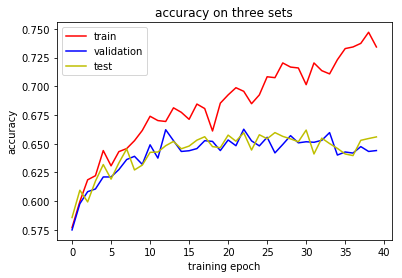

In [15]:
plt.figure(1)
ptr,=plt.plot(range(max_epoch),acc_train_his,'r-')
pva,=plt.plot(range(max_epoch),acc_val_his,'b-')
pte,=plt.plot(range(max_epoch),acc_test_his,'y-')
plt.xlabel('training epoch')
plt.ylabel('accuracy')
plt.title('accuracy on three sets')
plt.legend((ptr,pva,pte),('train','validation','test'))
plt.savefig('model-acc.png')
plt.show()

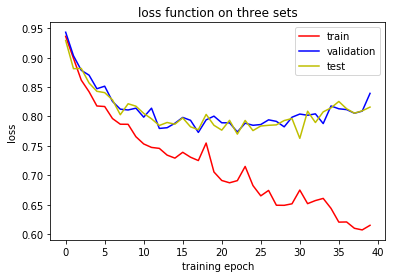

In [16]:
plt.figure(2)
ptr,=plt.plot(range(max_epoch),loss_train_his,'r-')
pva,=plt.plot(range(max_epoch),loss_val_his,'b-')
pte,=plt.plot(range(max_epoch),loss_test_his,'y-')
plt.xlabel('training epoch')
plt.ylabel('loss')
plt.title('loss function on three sets')
plt.legend((ptr,pva,pte),('train','validation','test'))
plt.savefig('model-loss.png')
plt.show()

In [21]:
saver=tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, "parameters/HAN.ckpt")
    loss_train,acc_train=eval(train_eval,1000)
    loss_val,acc_val=eval(validation,1000)
    loss_test,acc_test=eval(test,1000)
    print('Accuracy on training set is %.3f%%' % (acc_train*100.0))
    print('Accuracy on validation set is %.3f%%' % (acc_val*100.0))
    print('Accuracy on testing set is %.3f%%' % (acc_test*100.0))
    print()
    print('Total loss on training set is %f' % loss_train)
    print('Total loss on validation set is %f' % loss_val)
    print('Total loss on testing set is %f' % loss_test)

INFO:tensorflow:Restoring parameters from parameters/HAN.ckpt


2018-06-08 15:20:23,376 : INFO : Restoring parameters from parameters/HAN.ckpt


Accuracy on training set is 69.312%
Accuracy on validation set is 64.922%
Accuracy on testing set is 65.969%

Total loss on training set is 0.693348
Total loss on validation set is 0.780674
Total loss on testing set is 0.771007
